## Analysis of Design Iteration X

### Description

<br>
TEMPLATE <br>
DESCRIPTION <br>
FOR <br>
DESIGNS <br>
<br>

![alt text](block_diagram_template.png "Block Diagram")
*<p style="text-align: center;">Block Diagram</p>*


### Analysis

In [2]:
import pint
import os, sys

# ---------
# add lib folder to the path
def is_root(path):
    """
    Determine whether the path passed is the root directory for the file system
    """
    return not os.path.split(os.path.normpath(os.path.abspath(path)))[1]

def is_root_project_dir(path):
    """
    Determine whether the path specified is the root project directory by looking for 
    __mtk__.py in the directory. If the root file system directory is encountered, throw
    an exception
    """
    PROJECT_ROOT_FILE = '__mtk__.py'
    
    # make sure the path is in an OK format (ends with a directory separator)
    search_path = str(path)
    if (not search_path.endswith(os.sep)):
        search_path += os.sep
        
    # make sure the path isn't the root. if it is, there's a problem
    if (is_root(search_path)):
        raise Exception('Failed to locate root MTK directory (directory containint %s)' % PROJECT_ROOT_FILE)
        
    # check to see whether we can find the project root file in this path
    return os.path.isfile(search_path + PROJECT_ROOT_FILE)

def get_project_root():
    """
    Locate the project's root directory and return its location. If the root file system
    directory is encountered, throw an exception
    """
    search_path = os.getcwd() + os.sep
    count = 0
    while (not is_root_project_dir(search_path)):
        search_path = os.path.normpath(os.path.abspath(search_path + '..' + os.sep)) + os.sep
    return search_path

lib_path = get_project_root()
sys.path.insert(0, lib_path)
# ----------------

from lib.calculator import LinkBudgetCalculator
from tests.link_budget_test_case_dataset import LinkBudgetTestCaseDataset

Create a unit registry from pint that will be used throughout the analysis.

In [3]:
ureg = pint.UnitRegistry()

Create a function for the changing elevation angle and atmospheric loss values.

In [4]:
def atmloss_at_elev(elev):
    return -4.6 if elev < 5  * ureg.degrees else \
           -2.1 if elev < 10 * ureg.degrees else \
           -1.1 if elev < 30 * ureg.degrees else \
           -0.4 if elev < 45 * ureg.degrees else \
           -0.3 if elev < 90 * ureg.degrees else 0.0

def rx_pointing_loss_at_elev(elev):
    return -10.0 if elev < 5  * ureg.degrees else \
           -6.0  if elev < 20 * ureg.degrees else \
           -3.0  if elev < 35 * ureg.degrees else \
           -1.0  if elev < 50 * ureg.degrees else 0.0

Define variables for running a sweep over an orbital pass.

In [5]:
elev_max = 90 * ureg.degrees
elev_increment = 0.1

Instantiate a calculator object and set init values.

In [8]:
lb_calc = LinkBudgetCalculator(ureg)

tc_data = LinkBudgetTestCaseDataset(ureg)[0]

lb_calc.altitude_ground_station   = tc_data.altitude_ground_station
lb_calc.altitude_satellite        = tc_data.altitude_satellite
lb_calc.orbit_elevation_angle     = 0.0
lb_calc.downlink_frequency        = tc_data.downlink_frequency
lb_calc.target_energy_noise_ratio = tc_data.target_energy_noise_ratio
lb_calc.implementation_loss       = tc_data.implementation_loss
lb_calc.transmit_power            = tc_data.transmit_power
lb_calc.transmit_losses           = tc_data.transmit_losses
lb_calc.transmit_antenna_gain     = tc_data.transmit_antenna_gain
lb_calc.transmit_pointing_loss    = tc_data.transmit_pointing_loss
lb_calc.polarization_losses       = tc_data.polarization_losses
lb_calc.atmospheric_loss          = atmloss_at_elev(lb_calc.orbit_elevation_angle)
lb_calc.receive_antenna_gain      = tc_data.receive_antenna_gain
lb_calc.receiving_pointing_loss   = rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)
lb_calc.system_noise_figure       = tc_data.system_noise_figure
lb_calc.noise_bandwidth           = tc_data.noise_bandwidth

Increment through an entire orbital pass.

In [9]:
outputs = []
rising  = True

while rising or lb_calc.orbit_elevation_angle.magnitude > 0:
    # compute the budget
    lb_calc.run()
    
    # ensure the computation was valid
    if not lb_calc.is_valid:
        raise Exception('Run at elevation angle ', lb_calc.orbit_elevation_angle, ' was not valid')
    
    # save output as a tuple to output list
    outputs.append( (lb_calc.link_distance, \
                     lb_calc.downlink_path_loss, \
                     lb_calc.received_power, \
                     lb_calc.energy_noise_ratio, \
                     lb_calc.link_margin) )
    
    # handle the rising variable
    rising = not (not rising or lb_calc.orbit_elevation_angle >= elev_max)
    
    # increment the elevation angle
    lb_calc.orbit_elevation_angle += elev_increment if rising else -elev_increment

AttributeError: 'float' object has no attribute 'magnitude'

Once analysis has run, examine the results.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

# extract lists of the variables
margins = [ i[4] for i in outputs ]

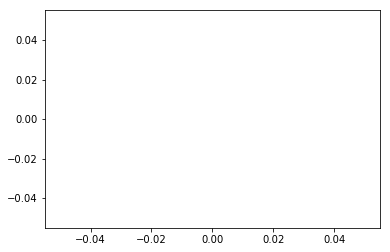

In [27]:
plt.plot(range(0,len(margins)), margins)

### Feedback from stand up

Eventually move to less boilerplate code in this document
    Place in another python file

Sections before Analysis for the set up of this specific analysis iteration
    Where values are specified

Check out open source libraries for orbits
    Astropy ?

Add tasks for the relevant work
Add tasks in Taiga for describing each subsection